## Идентификация пользователей по посещенным веб-страницам

**Примечание для проверяющего.** Информация по всем упомянутым разделам в 7 недели курса **содержится** в данном ноутбуке, но некоторые разделы переименованы и объединены для удобства восприятия.

### 1. Цели и задачи проекта

В данном проекте создаётся классификатор, предсказывающий пользователя по данным о веб-страницах, которые он посетил. Пользователи отличаются между собой по набору сайтов, по датам и времени посещения сайтов, по интервалам нахождения на конкретных сайтах и др.

Мы будем использовать продвинутые методы, отказавшись от ручного подхода: делать предсказания эмперически (т.е. на основе опыта человека). Во-первых, эмперические предсказания требуют человеческих затрат времени, во-вторых с помощью предсказательного моделирования мы можем обнаружить интересные закономерности, которые человек не всегда может описать. В-третьих, мы не привязываемся к конкретному человеку, который должен следить за трафиком сети.

Так, данный классификатор можно легко приспособить для любых типов пользователей, в том числе для идентификации пользователей, которые тратят слишком много времени на нежелательных сайтах. Просмотр посещенных сайтов может осуществлять робот, что и надёжнее для работодателя, и этичнее по отношению к сотрудникам. Не отвлекаясь напрасно на списки посещенных сайтов, не тратя время, можно получать уведомление лишь в том случае, если Ваш сотрудник явно нарушает рабочий режим.

### 2. Описание исходных данных

Данные представляют собой последовательные записи информации о каждом посещённом сайте в виде:

$(site_1, time_1, user_1), (site_2, time_2, user_1), ...(site_k, time_k, user_m)$

Т.е. мы имеем тройки, где $site_i$ — помещённый пользователем сайт, $time_i$ — время посещения сайта $site_k$, а $user_j$ — обозначение пользователя, который посетил $site_i$ во время $time_i$.

Эти данные мы используем для обучения классификатора. При этом в случае нежелательных сайтов можно подготовить разметку пользователя $user_i$ вручную: зная, например, кого-нибудь в организации, кто практически всё своё время проводит на развлекательных сайтах. Лучше, конечно, найти нескольких таких пользователей. И особенно хорошо этот подход должен работать, если у организации имеются свои сайты, над усовершенствованием которых трудятся сотрудники. В этом случае классификатор будет срабатывать, если пользователь отклонился от основной работы. 

Так, данные о нежелательных сайтах можно, например, собирать по тем дням, когда начальник отсутствовал на рабочем месте. Многие сотрудники при этом работают более расслабленно.

В рабочем режиме классификатора у нас не будет информации о пользователе $user_i$ (это и будет работа классификатора — определить пользователя).

Кроме того, данные поделены на сессии. Т.е. на предсказании известно, что конкретная последовательность из нескольких пар $site_i, time_i$ принадлежит только одному пользователю, правда, неизвестно кому конкретно. Иначе, если бы сессии пользователей были перемешаны по пользователям — в предсказаниях возникла бы трудность даже у человека.

### 3. Код контроля задач, используемый в ноутбуке

Было решено использовать собственное **средство изоляции ячеек.** Реализация в виде класса *Task* ниже.

Внутри каждой ячейки выполняются изолированная от глобальных переменных задача. Внешние переменные, используемые в задаче, не являются глобальными, а приходят в качестве формальных параметров в функцию задачи от предыдущей задачи. Это решает следующие проблемы:

1. Внешние глобальные переменные недоступны внутри задачи (недоступность поддержана). Таким образом, можно не придумывать длинные имена для переменных, чтобы они не совпадали с уже использованными глобальными переменными.
2. Мы можем быть уверены, что никакая переменная внутри задачи не была случайно инициализирована где-то ещё, в другой ячейке. Это помогает совершать меньше ошибок и экономит время поиска бага — в случае неожиданных результатов мы можем не пролистывать весь код в поисках возможной неправильной инициализации переменной, а можем сосредоточиться на конкретной ячейке, будучи уверенными, что проблема в текущем небольшом фрагменте кода.
3. Передача переменных между задачами **по типу pipe** удобна тем, что мы можем не беспокоиться о порядке выполнения ячеек, быть уверенными в том, что нужные ячейки выполнены. В противном случае, будет сгенерировано исключение, указывающее, что недостаёт данных после выполнения какой-то задачи — в этом случае можно сделать вывод, что требуемая предыдущая задача не была выполнена. В случае подобной ошибки значение никаких переменных не будет нарушено и можно просто выполнить недостающую задачу.

**Примечание.** Для указания, результат какой задачи будет использовать текущая задача, мы используем декоратор **@use_result().** Если никакого результата не требуется, т.к. задача сама начинает цепочку передачи данных, указанный декоратор использовать не нужно.

In [71]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import traceback
import pickle
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, hstack as sparse_hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from IPython.core.display import display, HTML

import re
import types
import inspect
from functools import partial

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import pylab

from MulticoreTSNE import MulticoreTSNE as TSNE

import seaborn as sns

from collections import Counter, OrderedDict
from datetime import datetime

import traceback

from sklearn.model_selection import validation_curve, learning_curve


class ResultDuplicateNextInfoKeyError(Exception): pass
class ResultNotFoundError(Exception): pass


class Result(object):
    def __init__(self, task_result=None, next_info=None):
        self.task_result = task_result
        self.next_info = next_info


    def __add__(self, other_result):
        summary_next_info = {}

        for key, val in self.next_info.iteritems():
            summary_next_info[key] = val

        for key, val in other_result.next_info.iteritems():
            if key in summary_next_info:
                raise ResultDuplicateNextInfoKeyError(
                    'There is a duplicate key %s in next_info when adding 2 results.' % repr(key))

            summary_next_info[key] = val

        return Result(next_info=summary_next_info)



class Task(object):
    _TASK_PREFIX = 'task_'
    _RE_NO_GLOBALS_REMOVE = '__\w+__'
    _LOCAL_GLOBALS = ['Result']
    _DECORATED_FUNC_NAME = '__decorated_func'


    def __init__(self):
        self._results = {}


    def _remove_globals(self, calling_globals):
        self._old_globals = {}
        for key, val in calling_globals.iteritems():
            if    re.match(self._RE_NO_GLOBALS_REMOVE, key) is None and key not in self._LOCAL_GLOBALS \
                    and not isinstance(val, types.ModuleType) and not callable(val):
                self._old_globals.update({key: val})

        for key in self._old_globals.keys():
            del calling_globals[key]


    def _restore_globals(self, calling_globals):
        for key in self._old_globals.iterkeys():
            calling_globals[key] = self._old_globals[key]

        self._old_globals = {}


    def call(self, name, use_result=None):
        calling_globals = globals()

        task_func = calling_globals[self._TASK_PREFIX + name]

        self._remove_globals(calling_globals)

        try:
            if task_func.__name__ == self._DECORATED_FUNC_NAME:
                result = task_func(name, self._results, use_result)
            else:
                next_info = use_result.next_info if use_result is not None else {}
                result = task_func(**next_info)
        except:
            print('There is an exception on executing task \'%s\': %s' % (name, sys.exc_info()[0]))
            print(traceback.format_exc())
        else:            
            if result is not None:
                if name in self._results:
                    print('Warning! The result of task \'%s\' is rewrited.' % name)

                self._results[name] = result

            if result is not None:
                if result.task_result is not None:
                    if isinstance(result.task_result, list) or isinstance(result.task_result, tuple):
                        task_result = [str(x) for x in result.task_result]
                        task_result = ' '.join(task_result)
                    else:
                        task_result = result.task_result


                    print('Result of task %s:\n%s' % (name, repr(task_result)))
        finally:
            self._restore_globals(calling_globals)


def use_result(*result_keys):
    def func_wrapper(task_func):
        def __decorated_func(task_name, results_obj, use_result):
            func_kwargs = {}

            for result_key in result_keys:
                try:
                    result_obj = results_obj[result_key]
                except KeyError:
                    raise ResultNotFoundError( \
'The result (in use_result) \'%s\' for task \'%s\' is not found. ' + \
'Probably an input task has not been executed yet.' % \
                                              (result_key, task_name))
                if use_result is not None:
                    result_obj = result_obj + use_result
                func_kwargs.update(result_obj.next_info)

            return task_func(**func_kwargs)

        return __decorated_func
    return func_wrapper

task = Task()

Добавляем классы **FeatureMaker** и **SitesData2** (вторая версия класса **SitesData,** использованного в предыдущих заданиях), которые синтезируют новые признаки на основе имеющихся данных.

In [72]:
class FeatureMaker(object):
    _DT_FORMAT = '%Y-%m-%d %H:%M:%S'
    _FACEBOOK_SITENAME = 'facebook.com'
    _WWW_PREFIX = 'www.'
    _DOT = '.'

    NUM_TOP_SITES_INDICATORS = 30
    SMALL_TIME_DIFFS_INTERVALS = [40, 20, 10, 5, 3, 1]    

    "Делаем недостающие признаки."
    def __init__(self, sites_by_freq, session_length, use_new_features):        
        self._sites_by_freq = sites_by_freq
        self._session_length = session_length
        self._top_sites = sites_by_freq.keys()[:self.NUM_TOP_SITES_INDICATORS]        
        self._use_new_features = use_new_features


    def _set_borders(self, session_start, end_pos):
        self._session_start = session_start
        self._end_pos = end_pos


    def set_user_data(self, user_data):
        self._user_data = user_data


    def get_columns(self):
        "Какие у нас есть колонки?"
        raise Exception('Not implemented.')


    def _last_pos(self):
        return self._end_pos if self._end_pos < self._user_data.shape[0] else self._end_pos - 1


    def _get_site_index(self, site_name):
        return self._sites_by_freq[site_name]

    
    @classmethod
    def _dt_from_str(cls, dt_str):
        return datetime.strptime(dt_str, cls._DT_FORMAT)


    def _dt_diff_seconds(self, first_index, second_index):
        first_dt = self._dt_from_str(self._user_data.ix[first_index].timestamp)
        second_dt = self._dt_from_str(self._user_data.ix[second_index].timestamp)

        return int((second_dt - first_dt).total_seconds())


    def _num_unique_sites(self):
        return len(self._sites_by_freq)


    def site(self):
        "Индексы сайтов, на которых побывал пользователь за сессию."
        site_indexes = []

        for cur_pos in xrange(self._session_start, self._end_pos):
            one_site_data = self._user_data.ix[cur_pos]
            site_index = self._get_site_index(one_site_data.site)

            site_indexes.append(site_index)

        site_indexes += [0 for x in xrange(self._session_length - len(site_indexes))] # дозаполнение нулями

        return site_indexes


    def time_diffs(self):
        """
            В задании допущена, на мой взгляд, некоточность. 
            Интервалов должно быть 10, чтобы не терять информацию о времени 
            пребывания на последнем сайте в сессии.
            Иначе некоторые другие признаки будут сформированы ТАКЖЕ с потерей последнего элемента сессии.
            Вторая неточность - предлагается дозаполнить time_diff для несуществующих сайтов нулями.
            Но ведь ведь в данных есть случаи, когда время прибывания на сайте действительно заняло
            0 секунд! Это значит, что так мы потеряем часть данных.

            Поэтому я дозаполнил несуществующие данные np.nan, а не 0, 
            чтобы модель была ближе к действительности.
            Что-то делать с этими np.nan можно уже походу 
            (например, заменять их на -1).
        """
        time_diffs = []

        for i in range(self._session_start, self._last_pos()):
            time_diffs.append(self._dt_diff_seconds(i, i + 1))
        for i in range(self._last_pos(), self._session_start + self._session_length):
            if self._use_new_features:
                time_diffs.append(-1)
            else:
                time_diffs.append(0)

        if not self._use_new_features:
            time_diffs.pop()

        self._time_diffs = time_diffs

        return time_diffs


    def session_timespan(self):
        last_pos = self._end_pos - 1
        return self._dt_diff_seconds(self._session_start, last_pos)


    def unique_sites(self):
        return len(self._user_data[self._session_start: self._end_pos].site.unique())


    def start_hour(self):
        dt = self._dt_from_str(self._user_data.ix[self._session_start].timestamp)
        return dt.hour


    def day_of_week(self):
        dt = self._dt_from_str(self._user_data.ix[self._session_start].timestamp)
        return dt.weekday()


    def day_month_year(self):
        "Год, месяц, день начала сессии."
        dt = self._dt_from_str(self._user_data.ix[self._session_start].timestamp)
        return (dt.day, dt.month, dt.year)


    def through_hour(self):
        "Час начала сессии (с учетом года, месяца и дня)."
        epoch_dt = datetime.fromtimestamp(0)
        dt = self._dt_from_str(self._user_data.ix[self._session_start].timestamp)

        td = dt - epoch_dt

        through_hour = int(td.total_seconds() / 3600.)

        return through_hour


    def _seconds_of_day_from_dt(self, dt):
        SECONDS_IN_MINUTE = 60
        SECONDS_IN_HOUR = SECONDS_IN_MINUTE * 60

        return dt.hour * SECONDS_IN_HOUR + dt.minute * SECONDS_IN_MINUTE


    def second_of_day(self):
        "Среднее Время суток (в секундах, т.е. середина сессии)."

        first_dt = self._dt_from_str(self._user_data.ix[self._session_start].timestamp)
        last_dt = self._dt_from_str(self._user_data.ix[self._last_pos()].timestamp)
        
        first_total_seconds = self._seconds_of_day_from_dt(first_dt)
        last_total_seconds = self._seconds_of_day_from_dt(last_dt)

        return int((first_total_seconds + last_total_seconds) / 2.)


    def avg_seconds_on_top_sites(self):
        intervals = []

        for i in range(self._last_pos() - self._session_start):
            site = self._user_data.ix[i].site

            if site in self._top_sites:
                intervals.append(self._time_diffs[i])

        num_intervals = len(intervals)

        if num_intervals > 0:
            return float(sum(intervals)) / num_intervals
        else:
            return 0


    def top_sites_ind(self):
        indicators = [0] * self.NUM_TOP_SITES_INDICATORS

        for i in range(self._session_start, self._end_pos):
            site = self._user_data.ix[i].site

            try:
                site_index = self._top_sites.index(site)
            except ValueError:
                pass
            else:
                indicators[site_index] = 1

        return indicators


    def facebook_num(self):
        num = 0

        for i in range(self._session_start, self._end_pos):
            site = self._user_data.ix[i].site
            if site.endswith(self._FACEBOOK_SITENAME):
                num += 1

        return num


    def www_sites(self):
        num = 0

        for i in range(self._session_start, self._end_pos):
            site = self._user_data.ix[i].site

            if site.startswith(self._WWW_PREFIX):
                num += 1

        return num


    def small_time_diffs(self):
        "Интервалы задаются в секундах."

        nums = []

        for i_interval in range(len(self.SMALL_TIME_DIFFS_INTERVALS)):
            nums.append(0)

        for i in range(self._last_pos() - self._session_start):
            time_diff = self._time_diffs[i]

            for i_interval, interval in enumerate(self.SMALL_TIME_DIFFS_INTERVALS):
                # если time_diff определён
                if not np.isnan(time_diff): 
                    if time_diff < interval:
                        nums[i_interval] += 1

        return nums


    def num_next_changes(self):
        num = 0

        cur_site = self._user_data.ix[0].site

        for i in range(self._session_start + 1, self._end_pos):
            next_site = self._user_data.ix[i].site

            if next_site != cur_site:
                num += 1
                cur_site = next_site

        return num


    def num_next_same(self):
        num = 0

        cur_site = self._user_data.ix[0].site

        for i in range(self._session_start + 1, self._end_pos):
            next_site = self._user_data.ix[i].site

            if next_site == cur_site:
                num += 1
                cur_site = None
            else:
                cur_site = next_site

        return num


    def num_most_freq_site(self):
        sites = [self._user_data.ix[i].site for i in range(self._session_start, self._end_pos)]
        return Counter(sites).most_common(1)[0][1]


    def _nums_dots(self):
        return [self._user_data.ix[i].site.count(self._DOT) for i in range(self._session_start, self._end_pos)]


    def avg_num_dots(self):
        nums = self._nums_dots()
        return float(sum(nums) / len(nums))


    def min_num_dots(self):
        return min(self._nums_dots())


    def max_num_dots(self):
        return max(self._nums_dots())


    def min_time_diff(self):
        time_diffs = filter(lambda x: x != -1, self._time_diffs)
        if len(time_diffs) == 0:
            time_diffs = [0]

        return min(time_diffs)


    @classmethod
    def _ts_hour(cls, timestamp):
        return datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S').hour


    def start_0_6(self):
        return 1 if 0 <= self._ts_hour(self._user_data.ix[0].timestamp) < 6 else 0


    def start_6_12(self):
        return 1 if 6 <= self._ts_hour(self._user_data.ix[0].timestamp) < 12 else 0


    def start_12_18(self):
        return 1 if 12 <= self._ts_hour(self._user_data.ix[0].timestamp) < 18 else 0


    def start_18_24(self):
        return 1 if 18 <= self._ts_hour(self._user_data.ix[0].timestamp) < 24 else 0


    def _get_new_features_frame_info(self):
        result = [
            (['day', 'month', 'year'], self.day_month_year),
            ('through_hour', self.through_hour),
            ('second_of_day', self.second_of_day),
            ('avg_seconds_on_top_sites', self.avg_seconds_on_top_sites),
            (['top_site_ind%d' % (i + 1) for i in range(self.NUM_TOP_SITES_INDICATORS)], self.top_sites_ind),
            ('facebook_num', self.facebook_num),
            ('www_sites', self.www_sites),
            (['small_time_diffs%d' % i for i in self.SMALL_TIME_DIFFS_INTERVALS], self.small_time_diffs),
            ('num_next_changes', self.num_next_changes),
            ('num_next_same', self.num_next_same),
            ('num_most_freq_site', self.num_most_freq_site),
            ('avg_num_dots', self.avg_num_dots),
            ('min_num_dots', self.min_num_dots),
            ('max_num_dots', self.max_num_dots),
            ('min_time_diff', self.min_time_diff),
            ('start_0_6', self.start_0_6),
            ('start_6_12', self.start_6_12),
            ('start_12_18', self.start_12_18),
            ('start_18_24', self.start_18_24),
        ]

        return result


    def name_site_columns(self):
        return ['site%d' % (i + 1) for i in xrange(self._session_length)]



    def _get_frame_info(self):
        end_timediff = self._session_length + 1 if self._use_new_features else self._session_length

        num_unique_sites = self._num_unique_sites()

        result = [
            (['time_diff' + str(i) for i in xrange(1, end_timediff)], self.time_diffs),
            ('session_timespan', self.session_timespan),
            ('#unique_sites', self.unique_sites),
            ('start_hour', self.start_hour),
            ('day_of_week', self.day_of_week)
        ]

        if self._use_new_features:
            result += self._get_new_features_frame_info()

        return result


    def _get_columns(self, get_func):
        cols = []

        for col_info, _ in get_func():
            if isinstance(col_info, basestring):
                cols.append(col_info)
            else:
                cols += list(col_info)

        return cols


    def get_columns(self):
        return self._get_columns(self._get_frame_info)


    def get_feature_row(self, session_start, end_pos):
        self._set_borders(session_start, end_pos)

        row = []

        for key, feature_func in self._get_frame_info():
            if callable(feature_func):
                feature_val = feature_func()            
            else:
                feature_val = feature_func

            if isinstance(feature_val, (list, tuple)):
                len_key = len(key)
                len_feature_val = len(feature_val)

                if len_key != len_feature_val:
                    raise Exception( \
                        'Wrong number feature values generated ' + 
                        'by feature maker method (len=%d) for columns %s (len must be %d)' \
                        % (len_feature_val, repr(key), len_key))

                row += list(feature_val)
            else:
                row.append(feature_val)
        
        return row


class SitesData2(object):
    _SESSION_LENGTH = 10

    def __init__(self, path_to_train_csv, path_to_test_csv, path_to_site_dic):
        self._path_to_train_csv = path_to_train_csv
        self._path_to_test_csv = path_to_test_csv
        self._path_to_site_dic = path_to_site_dic    

        self._load_sites_by_freq()    


    @classmethod
    def _load_data(cls, path_to_csv):
        return pd.read_csv(path_to_csv, index_col='session_id')


    def _load_sites_by_freq(self):
        with open(self._path_to_site_dic, 'rb') as f:
            self._sites_by_freq = pickle.load(f)
            self._freq_by_sites = {v: k for k, v in self._sites_by_freq.iteritems()}

        self._feature_maker = FeatureMaker( \
            sites_by_freq=self._sites_by_freq, 
            session_length=self._SESSION_LENGTH, 
            use_new_features=True
        )


    def _prepare_features(self, frame, stage=None):

        result_data = []
        targets = []

        num_rows = frame.shape[0]

        for num_row, row in frame.iterrows():
            timestamps = row[['time%d' % i for i in range(1, self._SESSION_LENGTH + 1)]]

            # здесь должны быть имена сайтов, а не индексы
            sites = row[['site%d' % i for i in range(1, self._SESSION_LENGTH + 1)]]
            sites = filter(lambda x: not np.isnan(x), sites)
            site_names = [self._freq_by_sites[site] for site in sites]
            timestamps = timestamps.values[:len(sites)]

            user_data = pd.DataFrame(data=dict(timestamp=timestamps, site=site_names))

            self._feature_maker.set_user_data(user_data) # в предыдущей версии разбито по-другому, посмотреть
            
            feature_row = self._feature_maker.get_feature_row(0, user_data.shape[0])
            result_data.append(feature_row)

            target = row.target if 'target' in row else None
            targets.append(target)


        return pd.DataFrame(result_data, columns=self._feature_maker.get_columns()), targets


    def prepare_train_features(self):
        train_frame = self._load_data(self._path_to_train_csv)
        self.train_feature_data, train_targets = self._prepare_features(train_frame, 'prepare_train_features')
        self.train_targets = np.array(train_targets)


    def prepare_test_features(self):
        test_frame = self._load_data(self._path_to_test_csv)
        self.test_feature_data, _ = self._prepare_features(test_frame, 'prepare_test_features')


    def prepare_site_cnts(self):
        train_df = self._load_data(self._path_to_train_csv)
        test_df = self._load_data(self._path_to_test_csv)

        train_test_df = pd.concat([train_df, test_df])

        train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
        train_test_sparse = frame_to_csr(train_test_df_sites.values)

        nrows_train_df = train_df.shape[0]

        self.train_site_cnts_data = train_test_sparse[:nrows_train_df,:]
        self.test_site_cnts_data = train_test_sparse[nrows_train_df:,:]


    @classmethod
    def _pickle(cls, path, frame):
        with open(path, 'wb') as f:
            pickle.dump(obj=frame, file=f)


    def pickle_train_features(self, path):
        self._pickle(path, self.train_feature_data)


    def pickle_train_targets(self, path):
        self._pickle(path, self.train_targets)        


    def pickle_test_features(self, path):
        self._pickle(path, self.test_feature_data)


    def pickle_train_site_cnts(self, path):
        self._pickle(path, self.train_site_cnts_data)


    def pickle_test_site_cnts(self, path):
        self._pickle(path, self.test_site_cnts_data)


    @classmethod
    def unpickle(cls, path):
        return pd.read_pickle(path)

Дополнительный код (графики, преобразование данных в разреженный вид).

In [59]:
class Singleton(type):
    _instances = {}
    def __call__(cls, *args, **kwargs):        
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)

        if len(args) > 0 or len(kwargs) > 0:
            raise SingletonError(
                'The class <%s> is a singleton and it\'s object can not be initialized more then once.' \
                % cls.__name__)

        return cls._instances[cls]
    
    
%matplotlib inline
    
def mult_dist(data, label, figsize=None, fontsize=None):
    "Распределение нескольких фич с помощью библиотеки seaborn."

    params = {}

    if figsize is not None:
        fig, ax = Plotter().get_plt().subplots(figsize=figsize)
        params['ax'] = ax

    for col in data.columns:
        col_data = data[col]

        params['data'] = col_data
        
        sns.kdeplot(**params)

    label_params = {'s': label}
    if label is not None:
        if fontsize is not None:
            label_params['fontsize'] = fontsize

        Plotter().get_plt().xlabel(**label_params)

    Plotter().get_plt().tight_layout()

    Plotter().get_plt().show()
    
def _plot_feature_distr(features, targets, feature_name):
    "Оценить распределения фичи feature_name при разных target."

    custom_features = features[feature_name]
    data = pd.concat([custom_features, pd.DataFrame(data=dict(target=targets))], axis=1)

    target_classes = np.unique(targets)

    plot_dict = {}
    for target_class in target_classes:
        plot_dict.update({'%s (target=%d)' % (feature_name, target_class): \
                          data[data.target==target_class][feature_name]})

    plot_data = pd.DataFrame(data=plot_dict)

    mult_dist(plot_data, label='Distribution of %s' % feature_name)
    
    
class DisabledCls(object):
    "При вызове любого метода, а также взятии индекса - ничего не делается."
    def __init__(self, *args, **kwargs):
        pass


    def __call__(self, *args, **kwargs):
        return DisabledCls()


    def __getitem__(self, key):
        return DisabledCls()


    def __getattr__(self, attr):
        return DisabledCls()



class Plotter(object):
    """
    Вспомогательный класс для отключения графиков (если идёт работа в обычной консоли Python,
    а не в ноутбуке).
    """
    __metaclass__ = Singleton

    def set_enabled(self, enabled):
        self._enabled = enabled


    def get_plt(self):
        if self._enabled:
            return plt
        else:
            return DisabledCls()
        
        
def frame_to_csr(X):
    """
    Входные данные. 2d массив (матрица), где каждая строка 
    - сессия с номерами сайтов (а не их частотами-количествами).
    Результат. Разреженная матрица частот (количеств), где частота 
    на пересечении строки (номер сессии) и столбца (индекс сайта).    
    """

    csr_rows = []
    csr_cols = []
    csr_data = []

    for num_row in xrange(X.shape[0]):

        row = X[num_row]
        num_occurencies = dict(zip(*np.unique(row, return_counts=True)))

        for element, num_element_occurencies in num_occurencies.iteritems():
            csr_rows.append(num_row)
            csr_cols.append(element)
            csr_data.append(num_element_occurencies)

    csr_X = sparse.csr_matrix((csr_data, (csr_rows, csr_cols)), shape=(X.shape[0], np.max(csr_cols) + 1))    
    csr_X = csr_X[:,1:] # первый столбец смысла не имеет, количество повторений 0 - такого индекса нет

    return csr_X


class HistParams(object):
    "Параметры гистограммы."
    def __init__(self, data, title, color, xticklabels=None, legend=None):
        self.data = data
        self.title = title
        self.color = color
        self.xticklabels = xticklabels
        self.legend = legend


def color_hist(x_caption, y_caption, *hist_params, **kwargs):
    "Код для рисования гистограмм."
    _DEFAULT_FIGSIZE = (16, 10)
    
    MAX_COLS = 2
    LEGEND_LOC = 'upper left'
    
    KEY_ROTATION = 'rotation'
    
    rotation = kwargs[KEY_ROTATION] if KEY_ROTATION in kwargs else 0

    num_hists = len(hist_params)

    # автоматически вычисляем параметры строк и колонок для подграфиков
    # (с учетом того, что количество колонок не может быть более 4)
    ncols = min(num_hists, MAX_COLS)
    nrows = int((num_hists - 1) / ncols) + 1

    figsize_dx, figsize_dy = _DEFAULT_FIGSIZE

    d_coeff = ncols / float(MAX_COLS)

    figsize_dx = d_coeff * figsize_dx
    figsize_dy = d_coeff * figsize_dy

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_dx, figsize_dy))

    for i, hist_param in enumerate(hist_params):
        if num_hists > 1:
            ax = axs[i] if num_hists > 1 else axs
            k = int(i / MAX_COLS)
            l = i % MAX_COLS
        else:
            ax = axs

        ax.set_title(hist_param.title)
        ax.set_xlabel(x_caption)
        ax.set_ylabel(y_caption)
        ax.yaxis.grid(True, color='lightgrey')
        ax.set_axisbelow(True)

        if hist_param.xticklabels is not None:
            labels = ax.set_xticklabels(hist_param.xticklabels, rotation=rotation)
            num_labels = len(hist_param.xticklabels)
            ax.hist(hist_param.data, color=hist_param.color, bins=range(num_labels + 1), align='left', rwidth=0.8)
            ax.set_xticks([i for i in range(num_labels)])

            if hist_param.legend is not None:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend([hist_param.legend])
        else:
            ax.hist(hist_param.data, color=hist_param.color, align='left', rwidth=0.8)
    
    plt.tight_layout()
    plt.show()

### 4. Предобработка данных

Исходные данные представлены последовательными записями о каждом посещённом сайте.

$(site_1, time_1, user_1), (site_2, time_2, user_1), ...(site_k, time_k, user_m)$

Предсказывать пользователя по двойке значений $site_1$, $time_1$ — большого смысла нет, т.к. этих данных слишком мало. Разные пользователи могут посетить один и тот же сайт в одно и то же время.

Поэтому будем захватывать некоторый интервал посещений, называемый **сессией.** Будем считать сессией последовательность

$(site_i, time_i, user_k), (site_{i+1}, time_{i+1}, user_k), ...(site_n, time_n, user_k)$

фиксированной длины. Т.е. будем брать не двойку значений $site_m$, $time_m$ и сопоставлять одному пользователю, а некоторый последовательный набор таких двоек, сопоставленных одному и тому же пользовоателю. Зададим параметр — длину сессии. Это максимальная длина данной последовательности.

Каждый сайт переведём в соответствующее число (индекс). Традиционные модели работают только с числами (или с повторяющимися знаковыми последовательностями, воспринимаемыми как категории — не наш случай). Поэтому просмотрим все сайты в выборке и нумеруем их. Один из способов нумерации — пусть сайты, которые встречаются чаще, соответствуют м**е**ньшему индексу. Названия сайтов в модели проигнорируем. Их можно использовать для генерации других признаков, например, признака "среднее количество точек-разделителей в именах сайтов текущей сессии". Код, переводящий название сайта в его номер, представлен в методе *top_site_ind()* класса *FeatureMaker.*

Каждая сессия должна быть одинаковой длины. Это нужно для того, чтобы воспользоваться традиционными моделями машинного обучения, где количество столбцов с признаками постоянно. Из-за того, что сессия может преждевременно заканчиваться, недополученные значения можно заполнить значениями по умолчанию, например, *нулями.*

В сессию можно включить номера сайтов. Код, генерирующий сессию, представлен медотом *_prepare_features()* класса *SitesData2.* 

Если просто включить номера сайтов в последовательном порядке (первый признак — номер первого сайта в сессии, второй признак — номер второго сайта в сессии и т.д.), то не все модели смогут эффективно обучаться на таком наборе признаков. Причина — признаки перекрываются. Т.е. первый сайт в текущей сессии может случайным образом отличаться от первого сайта в следующей сессии по причине фиксированной длины сессии. Наша сессия — это лишь приближение для обучения, реальный сеанс работы пользователя может быть длиннее. И первый признак может иметь для разных строк (сессий) разный смысл. 

Поэтому воспользуемся подходом "мешок слов" **(bag-of-words)** и будем работать не с последовательными номерами встречающихся сайтов, а используем для информации о сайтах другие признаки: пусть в столбце *k* хранится, сколько раз сайт с индексом *k* встретился в текущей сессии. Так мы получим довольно широкие матрицы признаков с большим количеством нулей, т.к. при небольшой длине сессии (10 сайтов) встретится в ней может не больше 10 разных сайтов, а всего разных сайтов в нашей выборке — десятки тысяч. 

Для хранения информации о сайтах используем разреженные матрицы (матрицы очень широкие, не поместятся в оперативной памяти). Код генерации признаков "bag-of-words" и создания разреженных матриц представлен в функции *frame_to_csr().*

Из времен посещения сайтов можно сгенерировать новые признаки. Cгенерируем дополнительные признаки, например
"час начала сессии", "временная длина сессии" и др.

Признаки вычисляются на основе одной сессии из 10 сайтов классом *FeatureMaker* (в методах *_get_new_features_frame_info()*, *_get_frame_info()* видны названия признаков и методы, исползуемые для их вычисления). Класс *SitesData* формирует сессию из последотельности двоек $site_m$, $time_m$ и занимается вспомогательными операциями вроде сохранения, считывания данных с диска.


### 5. Формальный анализ признаков

Проверим формат исходных данных. Все действия оформляем в виде отдельных задач с целью не допустить случайное изменение переменной другой ячейкой.

Будем работать с данными, разделенными на 2 класса. В начальной выборке есть много пользователей, но задача их разделения по данным посещённых сайтах слишком сложна, чтобы быть выполненной с точностью близкой хотя бы к 80% — так, глядя лишь на эти данные, человек бы регулярно путал одного пользователя с другим. Потому что, когда людей много, всегда найдутся очень похожие по стереотипам поведения. И, т.к. столбцов в данных довольно мало — всего название сайта и время, могут образоваться кластеры пользователей, посещающих одни и те же сайты в близкое время.

Поэтому будем работать с данными, где один пользователь отделен от других — попробуем с точностью не ниже 90% отделять целевого пользователя. Здесь и далее — будем называть пользователя именем **Элис.**

In [5]:
def task_load_data():
    train_df = pd.read_csv('data_5/train_sessions.csv')
    display(train_df.head())
    test_df = pd.read_csv('data_5/test_sessions.csv')
    display(test_df.head())
    
    return Result(next_info=dict(train_df=train_df, test_df=test_df))

task.call('load_data')

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,...,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,...,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
2,3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,...,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
3,4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,...,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
4,5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,...,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


#### 5.1 Просмотр имеющихся признаков

Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

Посмотрим на признаки, возможные пропуски **(NaN).**

In [12]:
@use_result('load_data') # это и задает pipe - от какой задачи принимаем данные (см. next_info пред. задачи)
def task_info(train_df, test_df, **kwargs):
    print('train_df.info():')
    display(train_df.info())
    print('train_df.head():')
    display(train_df.head())
    print('test_df.info():')
    display(test_df.info())
    print('test_df.head():\n')
    display(test_df.head())
    print('train_df[\'target\'].value_counts():')
    display(train_df['target'].value_counts())

    return Result(next_info=dict(nrows_train_df=train_df.shape[0], nrows_test_df=test_df.shape[0]))

task.call('info')

train_df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
session_id    253561 non-null int64
site1         253561 non-null int64
time1         253561 non-null object
site2         250098 non-null float64
time2         250098 non-null object
site3         246919 non-null float64
time3         246919 non-null object
site4         244321 non-null float64
time4         244321 non-null object
site5         241829 non-null float64
time5         241829 non-null object
site6         239495 non-null float64
time6         239495 non-null object
site7         237297 non-null float64
time7         237297 non-null object
site8         235224 non-null float64
time8         235224 non-null object
site9         233084 non-null float64
time9         233084 non-null object
site10        231052 non-null float64
time10        231052 non-null object
target        253561 non-null int64
dtypes: float64(9), int64(3), object(10)
memory usag

None

train_df.head():


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


test_df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82797 entries, 0 to 82796
Data columns (total 21 columns):
session_id    82797 non-null int64
site1         82797 non-null int64
time1         82797 non-null object
site2         81308 non-null float64
time2         81308 non-null object
site3         80075 non-null float64
time3         80075 non-null object
site4         79182 non-null float64
time4         79182 non-null object
site5         78341 non-null float64
time5         78341 non-null object
site6         77566 non-null float64
time6         77566 non-null object
site7         76840 non-null float64
time7         76840 non-null object
site8         76151 non-null float64
time8         76151 non-null object
site9         75484 non-null float64
time9         75484 non-null object
site10        74806 non-null float64
time10        74806 non-null object
dtypes: float64(9), int64(2), object(10)
memory usage: 13.3+ MB


None

test_df.head():



,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,...,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,...,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
2,3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,...,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
3,4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,...,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
4,5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,...,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


train_df['target'].value_counts():


0    251264
1      2297
Name: target, dtype: int64

#### 5.2. Получение новых признаков

В ходе задачи было установлено, что с помощью имеющихся признаков сложно получить модель приемлимого качества. Поэтому из исходных данных можно получить дополнительные признаки. 

Синтезируем новые признаки для анализа. Данные синтезируются с помощью 2 классов: *SitesData2* (вторая версия класса, изначально использованного в 3 неделе курса) и *FeatureMaker.*

In [75]:
def task_my_create_data( \
        path_to_train_csv, 
        path_to_test_csv, 
        path_to_site_dic, 
        path_train_features_pickle, 
        path_train_targets_pickle,
        path_test_features_pickle,
        path_train_site_cnts_pickle,
        path_test_site_cnts_pickle):

    sites_data2 = SitesData2( \
        path_to_train_csv=path_to_train_csv,
        path_to_test_csv=path_to_test_csv,
        path_to_site_dic=path_to_site_dic)
    
    sites_data2.prepare_train_features()
    sites_data2.pickle_train_features(path_train_features_pickle)    
    sites_data2.pickle_train_targets(path_train_targets_pickle)
    sites_data2.prepare_test_features()
    sites_data2.pickle_test_features(path_test_features_pickle)    
    sites_data2.prepare_site_cnts()
    sites_data2.pickle_train_site_cnts(path_train_site_cnts_pickle)
    sites_data2.pickle_test_site_cnts(path_test_site_cnts_pickle)
    
task.call( \
    'my_create_data', 
    use_result=Result(next_info=dict( \
            path_to_train_csv='data_5/train_sessions.csv',
            path_to_test_csv='data_5/test_sessions.csv', 
            path_to_site_dic='data/site_dic.pkl', 
            path_train_features_pickle='result/my_train_features.pkl', 
            path_train_targets_pickle='result/my_train_targets.pkl', 
            path_test_features_pickle='result/my_test_features.pkl',
            path_train_site_cnts_pickle='result/my_train_site_cnts.pkl',
            path_test_site_cnts_pickle='result/my_test_site_cnts.pkl'
        )
    )
)

Задача загрузки сгенерированных признаков, чтобы не генерировать их заново (это может быть долго), если случился перерыв в работе. В случае перерыва выполнять предыдущие задачи не обязательно, эта задача не связана по *pipe* с результатом предыдущих (не используется декоратор **@use_result()).** Достаточно выполнить ячейки инициализации библиотек и создания переменной ***task,*** что я и сделал.

In [27]:
def task_my_load_data( \
    path_train_features_pickle, 
    path_train_targets_pickle, 
    path_test_features_pickle,
    path_train_site_cnts_pickle,
    path_test_site_cnts_pickle):

    train_features = SitesData2.unpickle(path_train_features_pickle)
    train_targets = SitesData2.unpickle(path_train_targets_pickle)
    test_features = SitesData2.unpickle(path_test_features_pickle)
    train_site_cnts = SitesData2.unpickle(path_train_site_cnts_pickle)
    test_site_cnts = SitesData2.unpickle(path_test_site_cnts_pickle)
    
    elice_indices = np.where(train_targets==1)[0]
    other_indices = np.where(train_targets!=1)[0]

    return Result(next_info=dict( \
        train_features=train_features,
        train_targets=train_targets,
        test_features=test_features,
        train_site_cnts=train_site_cnts,
        test_site_cnts=test_site_cnts,
        elice_indices=elice_indices,
        other_indices=other_indices))

task.call('my_load_data', use_result=Result(next_info=dict( \
                path_train_features_pickle='result/my_train_features.pkl', 
                path_train_targets_pickle='result/my_train_targets.pkl', 
                path_test_features_pickle='result/my_test_features.pkl',
                path_train_site_cnts_pickle='result/my_train_site_cnts.pkl',
                path_test_site_cnts_pickle='result/my_test_site_cnts.pkl'
            )
        )
    )

#### 5.3. Формальный анализ признаков

Медианная, минимальная, максимальная продолжительсть сессии для целевого пользователя Элис и всех остальных пользователей.

In [5]:
@use_result('my_load_data')
def task_median_session_timespan(train_features, train_targets, elice_indices, other_indices, **kwargs):
    print('Убедимся, что классов всего 2, выведем уникальные классы:', np.unique(train_targets))
    print('Медианная продолжительность сессии Элис:', train_features.iloc[elice_indices]['session_timespan'].median())
    print('Медианная продолжительность сессии других пользователей:', train_features.iloc[other_indices]['session_timespan'].median())
    print('Минимальная продолжительность сессии:', train_features['session_timespan'].min())
    print('Максимальная продолжительность сессии:', train_features['session_timespan'].max())
    
task.call('median_session_timespan')

Убедимся, что классов всего 2, выведем уникальные классы: [0 1]
Медианная продолжительность сессии Элис: 11.0
Медианная продолжительность сессии других пользователей: 28.0
Минимальная продолжительность сессии: 0
Максимальная продолжительность сессии: 1800


Всё правильно, в описании данных было сказано, что сессии длиннее чем полчаса (1800 секунд) обрезаются. В то же время, если в сессии только два сайта и интервал между их посещением менее чем 1 секунда — то сессия имеет нулевую длину в секундах.

Медианный день недели. Также выведем минимальный и максимальный день, чтобы увидеть, с какого числа нумеруются дни - с ноля или с единицы.

In [43]:
@use_result('my_load_data')
def task_median_session_dayofweek(train_features, train_targets, elice_indices, other_indices, **kwargs):
    # 1 - вторник, второй день
    print('Медианный день недели Элис:', train_features.iloc[elice_indices]['day_of_week'].median())
    # 2 - среда, третий день
    print('Медианный день недели других пользователей:', train_features.iloc[other_indices]['day_of_week'].median())
    print('Номер первого дня в неделе:', train_features['day_of_week'].min())
    print('Номер последнего дня в неделе:', train_features['day_of_week'].max())
    
task.call('median_session_dayofweek')

Медианный день недели Элис: 1.0
Медианный день недели других пользователей: 2.0
Номер первого дня в неделе: 0
Номер последнего дня в неделе: 6


Медианный час начала сессии.

In [46]:
@use_result('my_load_data')
def task_median_session_starthour(train_features, train_targets, elice_indices, other_indices, **kwargs):
    print('Медианный час начала сессии Элис:', train_features.iloc[elice_indices]['start_hour'].median())
    print('Медианный час начала сессии других пользователей:', train_features.iloc[other_indices]['start_hour'].median())
    
task.call('median_session_starthour')

Медианный час начала сессии Элис: 16.0
Медианный час начала сессии других пользователей: 12.0


Медианное значение числа уникальных сайтов.

In [12]:
@use_result('my_load_data')
def task_median_session_uniquesites(train_features, train_targets, elice_indices, other_indices, **kwargs):
    print('Медианное число уникальных сайтов в сессии Элис:', train_features.iloc[elice_indices]['#unique_sites'].median())
    print('Медианное число уникальных сайтов в сессии других пользователей:', train_features.iloc[other_indices]['#unique_sites'].median())
    
task.call('median_session_uniquesites')

Медианное число уникальных сайтов в сессии Элис: 6.0
Медианное число уникальных сайтов в сессии других пользователей: 6.0


### 6. Визуальный анализ исходных данных и признаков

Посмотрим на разность распределения признаков Элис и других пользователей.

#### 6.1. Сравнение распределений некоторых признаков.

In [5]:
@use_result('my_load_data')
def task_hist_data(train_features, elice_indices, other_indices, **kwargs):
    
    color_dict = {1: 'magenta', 0: 'gray'} # для Элис розовый цвет, для других — серый
    usernames = {1: u'Элис', 0: u'Другие пользователи'}
    
    features_by_user = {1: train_features.iloc[elice_indices], 0: train_features.iloc[other_indices]}

    return Result(next_info=dict(color_dict=color_dict, usernames=usernames, features_by_user=features_by_user))

task.call('hist_data')

Распределение продолжительности сессии Элис и других пользователей.

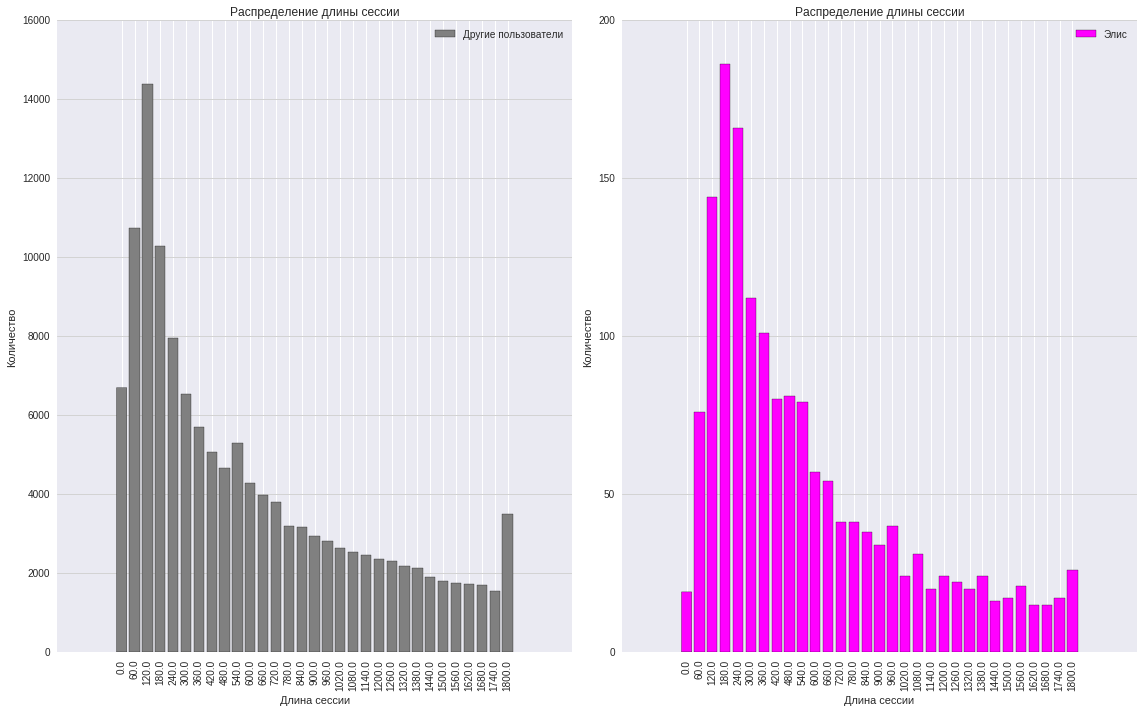

In [13]:
@use_result('hist_data')
def task_hist_session_timespan(features_by_user, color_dict, usernames, **kwargs):
    hist_params = []

    for target, username in usernames.iteritems():
        plot_data = features_by_user[target]['session_timespan']

        hist_params.append(
            HistParams(
                data=plot_data, 
                title=u'Распределение длины сессии',
                color=color_dict[target],
                xticklabels=np.linspace(0, 1800, 31),
                legend=username
            )
        )

    color_hist(u'Длина сессии', u'Количество', *hist_params, rotation=90)
    
task.call('hist_session_timespan')

Соответсвующие графики для числа уникальных сайтов в сессии — для Элис и других пользователей.

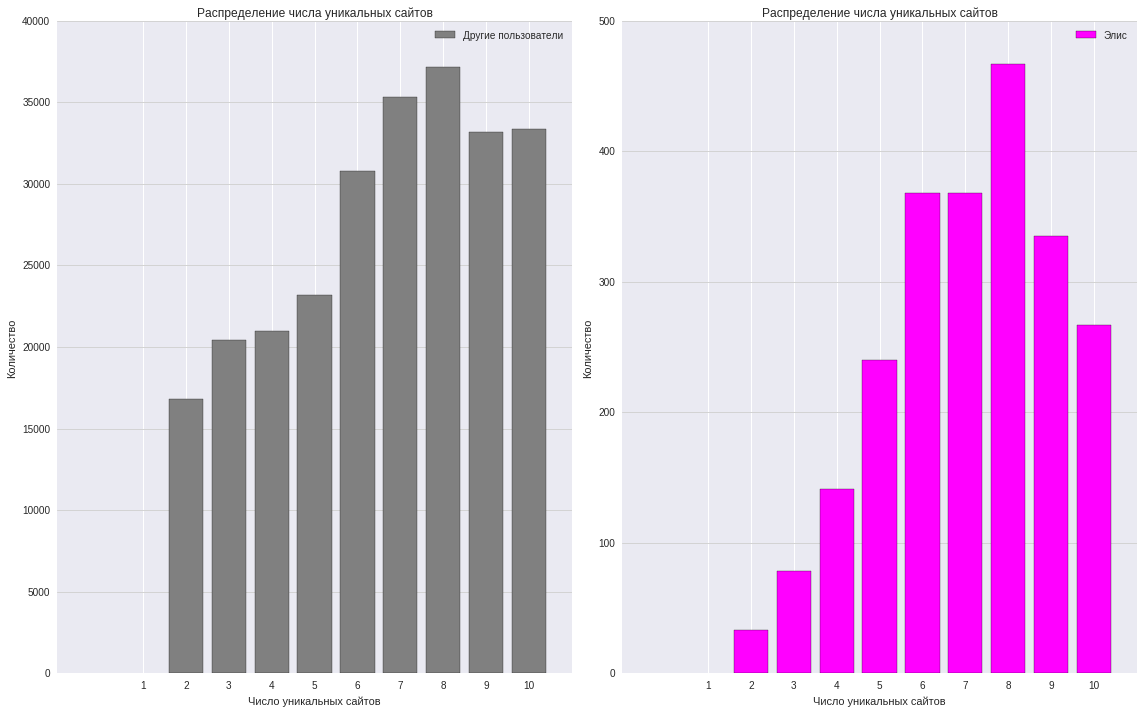

In [14]:
@use_result('hist_data')
def task_hist_unique_sites(features_by_user, color_dict, usernames, **kwargs):
    hist_params = []

    for target, username in usernames.iteritems():
        plot_data = features_by_user[target]['#unique_sites']

        hist_params.append(
            HistParams(
                data=plot_data, 
                title=u'Распределение числа уникальных сайтов',
                color=color_dict[target],
                xticklabels=range(1, 11),
                legend=username
            )
        )

    color_hist(u'Число уникальных сайтов', u'Количество', *hist_params)
    
task.call('hist_unique_sites')

Распределение часа начала сессии.

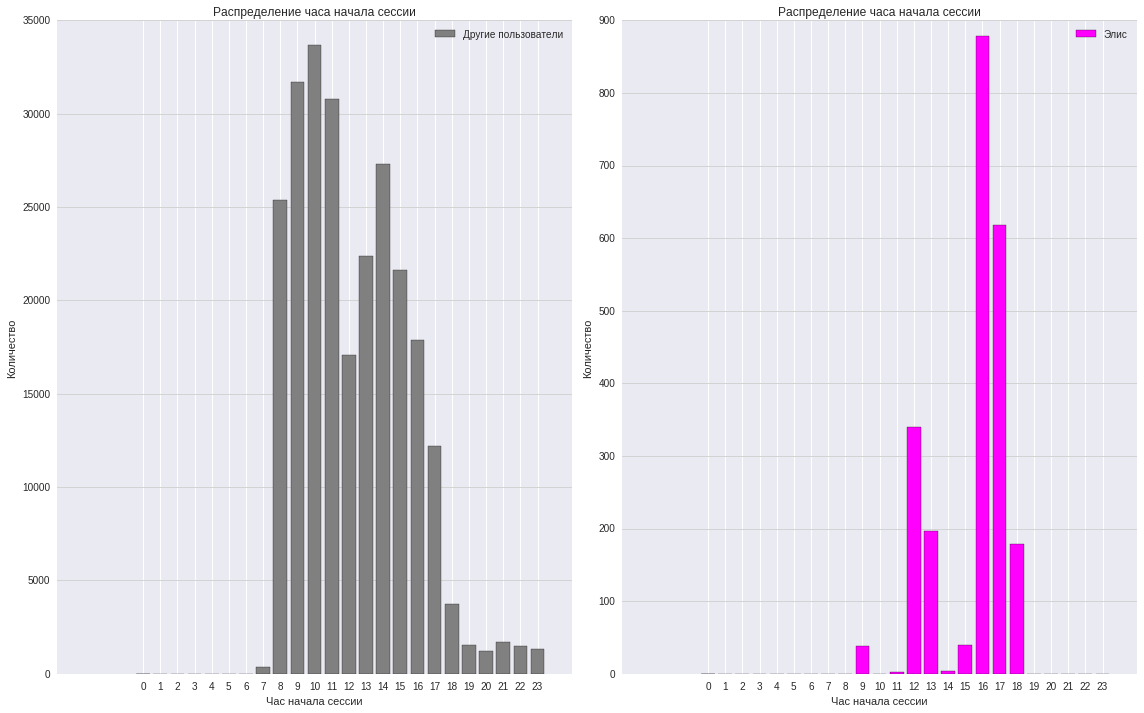

In [15]:
@use_result('hist_data')
def task_hist_start_hour(features_by_user, color_dict, usernames, **kwargs):
    hist_params = []

    for target, username in usernames.iteritems():
        plot_data = features_by_user[target]['start_hour']

        hist_params.append(
            HistParams(
                data=plot_data, 
                title=u'Распределение часа начала сессии',
                color=color_dict[target],
                xticklabels=range(0, 24),
                legend=username
            )
        )

    color_hist(u'Час начала сессии', u'Количество', *hist_params)
    
task.call('hist_start_hour')

День недели, в который началась сессия.

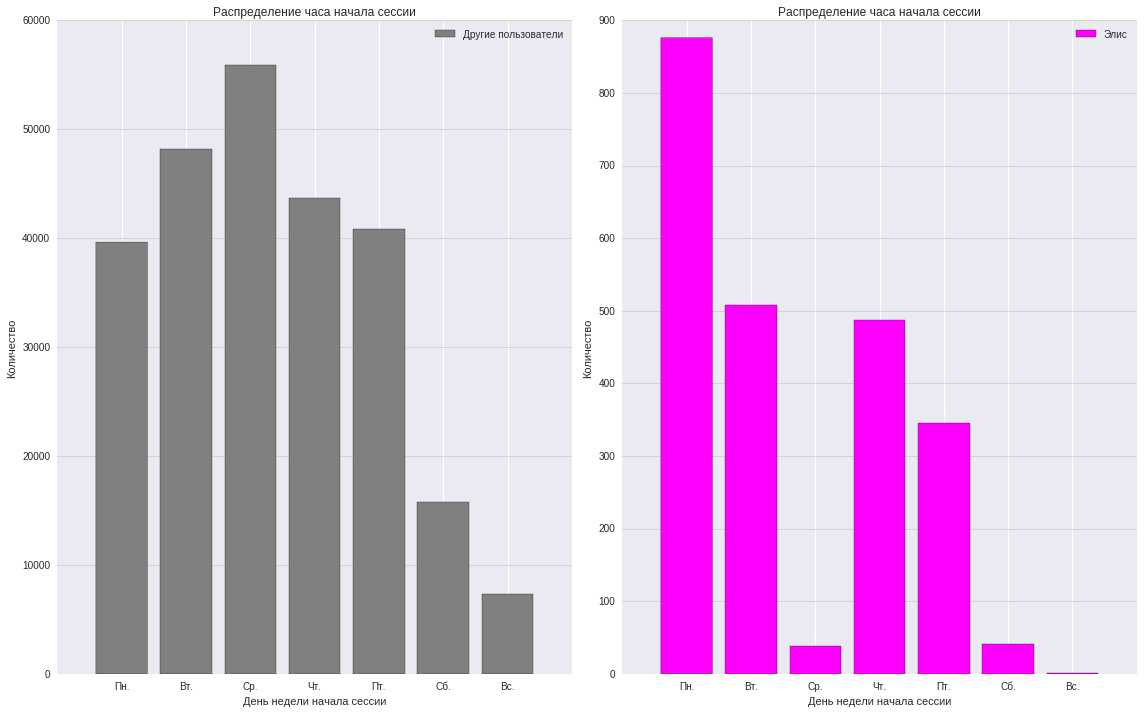

In [16]:
@use_result('hist_data')
def task_hist_day_of_week(features_by_user, color_dict, usernames, **kwargs):
    hist_params = []

    for target, username in usernames.iteritems():
        plot_data = features_by_user[target]['day_of_week']

        hist_params.append(
            HistParams(
                data=plot_data, 
                title=u'Распределение часа начала сессии',
                color=color_dict[target],
                xticklabels=[u'Пн.', u'Вт.', u'Ср.', u'Чт.', u'Пт.', u'Сб.', u'Вс.'],
                legend=username
            )
        )

    color_hist(u'День недели начала сессии', u'Количество', *hist_params)
    
task.call('hist_day_of_week')

### 7. Результаты анализа (закономерности) в исходных признаках

Потенциально видны 2 полезных признака — это час начала сессии **(start_hour)** и день начала сессии **(day_of_week).**  Распределения этих признаков имеют моды (пики), сильно отличающиеся от мод на соответствующих графиках для других пользователей, т.е. данные признаки у сессий Элис чаще принимают значения, отличные от значений для сессий других пользователей (не-Элис).

Распределения 2 других признаков (длина сессии **session_length** и число уникальных сайтов **#unique_sites**) cхожи для Элис и других пользователей. Отдельные значения у Элис отличаются, но это похоже на влияние выборки б**о**льшего размера (другие пользователи, не-Элис), задающей распределение, которое ближе к унимодальному, плавно спадающему. У Элис из-за м**е**ньшего размера данных распределение кое-где немного отклоняется от заданного (допустим, у Элис получилось сессий длины в 10 сайтов в целом больше, чем у большинства), но всё равно заметно, что распределение, которому соответствует этот признак, имеет похожую природу, что и для не-Элис.

### 8. Новые признаки

Для лучшей работы классификатора очень желательно извлечь из данных лишь о сайтах и времени посещения дополнительные признаки. К недостаткам математической модели, которой является классификатор, относится непонимание особенностей данных, присущее человеку. Поэтому необходимо сформировать новую информацию и, кроме всего двух признаков о названии и времени посещения сайтов, добавить дополнительные, которые переведут наши эмперические знания на язык математики.

Кроме того, данные можно представить в виде сессии, т.е. рассматривать не по одной паре $site_i, time_i$, а брать, например, сразу 10 пар этих данных. И, допустим, сопоставлять эти 10 пар из конкретной сессии одному пользователю. Так данных в строке будет больше.

Можно пробовать разные длины сессий, делать сессии перекрывающимися.

Ниже представлены новые признаки, которые могут быть получены из исходных данных.

* **time_diff1, time_diff2, ..., time_diff10** – интервал между двумя сайтами в секундах, время пребывание на сайте;
* **session_timespan** – количество секунд между началом и концом сессии;
* **unique_sites** – количество уникальных сайтов;
* **start_hour** – час начала сессии;
* **day_of_week*** – день недели начала сессии;
* **day, month, year** – день, месяц и год;
* **through_hour** – сквозной час (сколько часов прошло с 1 января 1970 года, т.е. с "эпохи");
* **second_of_day** – номер секунды дня;
* **avg_seconds_on_top_sites** – среднее количество секунд, проведённое на топ-10 сайтах в текущей сессии;
* **top_site_ind** – индикаторы топовых сайтов, всего 10 (1 – если в данной сессии был заход на соотв. топовый сайт, иначе 0);
* **facebook_num** – сколько раз пользователь зашёл на facebook.com;
* **www_sites** – сколько раз пользователь зашёл на сайт, начинающийся с префикса www.;
* **small_time_diffs** – сколько в текущей сессии встречается коротких сессий, меньших 40, 20, 10, 5, 3, 1 секунды
* **num_next_changes** – сколько раз следующий сайт в сессии отличался от предыдущего (отражает, насколько пользователь склонен менять сайт при очередном перемещении);
* **num_next_same** – количество пар, когда предыдущий сайт такой же, как последующий; пара считается законченной, если был найден повторяющийся сайт, т.е. следующий сайт, если он такой же - не принадлежит к найденной паре;
* **num_most_freq_site** – сколько раз был посещён самый частый сайт в данной сессии; отражает, склонен ли пользователь часто ходить по одному сайту;
* **avg_num_dots, min_num_dots, max_num_dots** – среднеарифметическое, минимальное и максимальное количества точек (разделителей) в имени сайта в сессии;
* **min_time_diff** – минимальный интервал между временем посещения двух сайтов в сессии.
* **start_0_6** – началась ли сессия в интервале [0, 6) часов.
* **start_6_12*** – началась ли сессия в интервале [6, 12) часов.
* **start_12_18** – началась ли сессия в интервале [12, 18) часов.
* **start_18_24** – началась ли сессия в интервале [18, 24) часов.

Признаки, помеченные звёздочками (т.е. день недели и индикатор, началась ли сессия пользователя от 6 утра и до 12 дня) дали улучшение модели и были добавлены в новую модель.

Кроме того, над признаками названий сайтов лучше поработать. Во-первых, нужно их перевести в числовой вид. Большинство моделей успешно работают только с числами. Во-вторых, после перевода сайтов в их номера (числа) возникнет проблема, что признак $sitenum_k$ будет зависеть от того, как мы разбили сессию. Т.е. в строке, допустим 2 на месте сайта 3 будет один номер, в следующей строке на этом же месте вероятнее всего окажется другой номер, никак не связанный по смыслу с предыдущим номером сайта. Признак будет иметь нечёткий смысл, будет сильно меняться и модель будет обучаться хуже.

Если же применить подход **bag-of-words**, т.е. на месте $site_i$ вписывать не номер i-го сайта в сессии, а, например, количество, сколько раз встретился $site_i$ в сессии, то признак сразу приобретает чёткий смысл для всех строк. Т.е. новые строки будут давать дополнительную информацию: классификатор сможет настраивать корректно веса модели исходя из конкретного признака $i$.

Будем использовать в качестве новых признаков также указанные количества использованных сайтов, а номера сайтов исключим из модели, т.к. новые признаки о количестве сайтов уже содержат информацию о посещённых сайтах. Последовательность перехода между сайтами, которая не учтена в данном преобразовании, можно учесть в дополнительных признаках, например, в таких признаках как **num_next_same** (см. описание признаков выше).

### 9. Отделимость классов

Строить картинку отделимости классов методом **t-SNE (t-Distributed Stochastic Neighbor Embedding),** например, затратно с точки зрения процессорного времени. Так как у нас есть другие более быстрые и не менее эффективные методы визуального анализа, приведу лишь сгенерированную ранее картинку **t-SNE** для разных классов (когда была поставлена другая задача на тех же данных: отделить всех пользователей).

Видно, что большое количество пользователей отделить очень сложно. Тут, наверное, ошибался бы даже человек. Привожу картинку с целью дать представление о сложности такой задачи. Классы, окрашенные в разные цвета, расположены при проекции в 2d-пространство без каких-то понятных законов, они особенно нигде не кластеризуются.

<img src='https://www.dropbox.com/s/1hho0ywh5bafxmj/tsne_many_users.png?raw=1'>

### 10. Обучение модели, кросс-валидация и кривые валидации

#### 10.1 Обучение модели и кросс-валидация

Новые признаки в модель добавлялись постепенно, по одному. При этом я использовал три метрики для оценки бинарной классификации (Элис, не-Элис): **accuracy, precision и recall.** При этом я сравнивал предыдущую модель с новой, в которую добавлялся новый признак.

Об однозначном улучшении модели бинарной классификации (для любой бизнес-задачи) можно сказать более или менее однозначно, если **accuracy, precision и recall** улучшились. Почему именно все три эти метрики для любой задачи?

1. Если у нас улучшилась только **accuracy,** значит, мы стали точнее различать положительные и отрицательные классы. В целом это неплохо, но если ухудшилась метрика **recall,** значит, теоретически бизнес-задача может быть решена хуже, чем с предыдущей моделью, с худшим параметром **accuracy.** Если в бизнес-задаче стоит условие, чтобы находить как можно больше сессий Элис, то новая модель работает с точки зрения клиента хуже. Представим, что в выборке у нас очень много объектов отрицательного класса (не-Элис). Улучшение **accuracy** может означать, что модель стала давать меньше положительных срабатываний и стала лучше находить объекты отрицательного класса. В то же нельзя однозначно сказать что-то о качестве нахождения классов Элис, ведь выборка сильно несбалансирована.

2. Улучшение **recall,** с другой стороны, означает нахождение большего числа объектов Элис. Но если в нашей бизнес-задаче стоит условие, чтобы не находить положительные объекты попусту (допустим, чтобы не посылать руководителю лишних логов), а найти только точно соответствующие Элис, то с точки зрения этой задачи улучшение **recall** не обязательно означает улучшение модели.

3. И аналогично для **precision.** Улучшение **precision** лучше подойдёт, если клиент хочет точнее найти объекты Элис, но при этом многие объекты могут быть не обнаружены. Так, если бы мы строили классификатор для определения потенциальных сотрудников (должен или не должен быть нашим сотрудником) или для определения потенциальных клиентов, которым стоило бы отправить сообщение о новогодней акции, то мы рисковали бы многих их них проигнорировать.

Так, в связи с тем, что задача недоопределена (что именно хочет получить заказчик), будем смотреть на все три эти метрики. В качестве примера я привожу 2 задачи, одна из которых содержит дополнительный добавленный параметр, а другая — два дополнительных параметра. При этом модели сравниваются по указанным метрикам: **accuracy, precision, recall.**

**Кросс-валидация** для усреднения данных метрик проводилась на 3 фолда.

In [7]:
@use_result('my_load_data')
def task_my_all_model_quality_prev(train_features, train_targets, train_site_cnts, **kwargs):
    sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

    trunc_train_features = train_features[['day_of_week']]

    X = sparse_hstack( (csr_matrix(trunc_train_features.values), train_site_cnts) )

    y = train_targets

    cross_val_score_part = partial(cross_val_score, estimator=sgd_logit, X=X, y=y, cv=3)

    print('Accuracy: %.7f' % cross_val_score_part(scoring='accuracy').mean())
    print('Precision: %.7f' % cross_val_score_part(scoring='precision').mean())
    print('Recall: %.7f' % cross_val_score_part(scoring='recall').mean())
    print('Roc_auc: %.7f' % cross_val_score_part(scoring='roc_auc').mean())
    
task.call('my_all_model_quality_prev')

Accuracy: 0.9912447
Precision: 0.6634272
Recall: 0.0679164
Roc_auc: 0.9208248


Признак day_of_week дал улучшение параметров и был добавлен к модели ранее. Попробуем также добавить сгенерированный признак **start_6_12,** означающий, началась ли сессия в интервале [6; 12) часов.

In [8]:
@use_result('my_load_data')
def task_my_all_model_quality(train_features, train_targets, train_site_cnts, **kwargs):
    sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

    check_feature = 'start_6_12'

    trunc_train_features = train_features[['day_of_week', check_feature]]

    X = sparse_hstack( (csr_matrix(trunc_train_features.values), train_site_cnts) )

    y = train_targets

    cross_val_score_part = partial(cross_val_score, estimator=sgd_logit, X=X, y=y, cv=3)

    print('Accuracy: %.7f' % cross_val_score_part(scoring='accuracy').mean())
    print('Precision: %.7f' % cross_val_score_part(scoring='precision').mean())
    print('Recall: %.7f' % cross_val_score_part(scoring='recall').mean())
    print('Roc_auc: %.7f' % cross_val_score_part(scoring='roc_auc').mean())
    
task.call('my_all_model_quality')

Accuracy: 0.9914616
Precision: 0.6942328
Recall: 0.1027390
Roc_auc: 0.9508164


Видим, что все 3 метрики **(accuracy, precision, recall)** на кросс-валидации одназначно улучшились. Добавим также признак **start_6_12** к итоговой модели.

**Примечание.** Попытка настройки гиперпараметра $ \alpha $ модели SGDClassifier с логистической функцией потерь (log_loss) в данном случае *не дало* сколько-нибудь улучшения в качестве классификации. На тренировочный данных был найден гиперпараметр, близкий по значению к $alpha$ по умолчанию, что дало незначитальное улучшение, а классификация на тестовых данных (которые были посланы на **kaggle.com)** стала с настроенным параметром даже хуже, метрика **kaggle.com** ухудшилась.

**Результат.** Оба бенчмарка: "sgd_logit_benchmark.csv" и "Logit +3 features" побиты. См. [результаты](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard) на Leaderboard для команды **[YDF & MIPT] Coursera_zaharov** (score=0.94069). Очки для бенчмарка "Logit +3 features" score=0.92784. В курсе Яндекса/МФТИ по анализу данных на coursera.com требовалось побить эти уровни для получения максимальной оценки за работу.

#### 10.2. Кривые валидации

Кривые валидации позволяют определить зависимость какой-либо метрики качества от гиперпараметра модели. Будем использовать быстрый классификатор градиентного спуска с функцией потерь log_loss (логистическая функция потерь).

Исследуем гиперпараметр модели $\alpha$ (*alpha*). Напомню, что этот гиперпараметр влияет на чувствительность модели (связан с регуляризацией). При понижении чувствительности модель будет меньше реагировать на отклонения в данных и с меньшей вероятностью переобучится, с другой стороны, модель может упускать некоторые закономерности в данных. Следует подбирать оптимальный параметр чувствительности модели.

Построим кривую для двух метрики **ROC_AUC**.

**Кривая для метрики *roc_auc.***

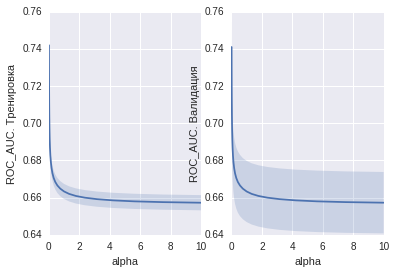

In [66]:
def plot_with_err(ax, x, data, xlabel, ylabel):
    mu, std = data.mean(1), data.std(1)
    lines = ax.plot(x, mu, '-')
    ax.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

@use_result('my_load_data')
def task_validation_curve_alpha_rocauc(train_features, train_targets, train_site_cnts, **kwargs):
    alphas = np.logspace(-2, 1, 25)
    
    sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
    
    trunc_train_features = train_features[['day_of_week', 'start_6_12']]
    X = sparse_hstack( (csr_matrix(trunc_train_features.values), train_site_cnts) )
    y = train_targets
    
    val_train, val_valid = validation_curve(sgd_logit, X, y, 'alpha', alphas, cv=5, scoring='roc_auc')
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    
    plot_with_err(ax1, alphas, val_train, xlabel=r'alpha', ylabel=u'ROC_AUC. Тренировка')
    plot_with_err(ax2, alphas, val_valid, xlabel=r'alpha', ylabel=u'ROC_AUC. Валидация')
    plt.legend();
    
task.call('validation_curve_alpha_rocauc')

**Вывод.** Я не исследовал глубоко требуемое значение *alpha*, видно, что главное — лучшее $\alpha$ в районе долей единицы, причём практически разницы в параметре ROC_AUC при *alpha* < 0.1 нет (**ROC_AUC** в районе 0.74). Поэтому примем данный параметр по умолчанию ($\alpha = 0.0001$).

Тем более ответов на данных, которых мы будем предсказывать, нет, поэтому не будем сильно замочариваться глубокой настройкой параметра, который слабо влияет на качество модели в определённом интервале.

Выбранное значение $\alpha$ можно подтвердить или опровергнуть на кривых обучения (следующий подраздел). Если модель при выбранном значении $\alpha$ продолжает обучаться при увеличении количества данных, значит, $\alpha$ приемлимый.

#### 10.3. Кривые обучения

Кривые обучения показывают **поведение метрики качества обучения при увеличении количества новых данных.** По оси *y* — метрика **ROC_AUC,** по оси *x* — размер обучающей выборки. В идеале при увеличении размера обучающей выборки кривая на тесте должна приближаться к кривой на валидации, при этом кривая на валидации должна подниматься всё выше и выше (качество на данных, которые модель не видела, должно расти при увеличении размера обучающей выборки до некоторого порога, когда модель уже перестаёт обучаться). 

Анализ кривых валидации позволяет не только установить корректность модели, но и оценить потенциал модели обучаться дальше (если будут получены ещё данные). Если кривая валидации пришла к некоторому верхнему пределу — новые данные вряд ли улучшат модель.

Построим кривые вадилации по двум метрикам: по **accuracy** и по **ROC_AUC.**

**Примечание.** Посмотрим, как сближаются кривые при разных $\alpha$.

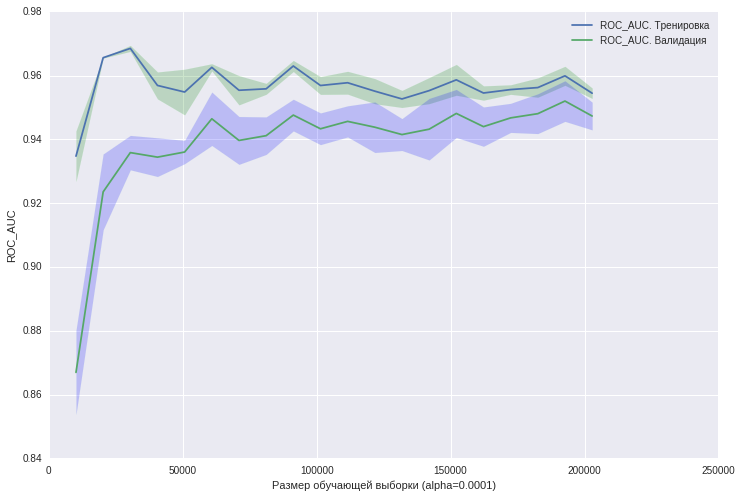

In [68]:
def plot_with_err2(x, data, label, edgecolor, facecolor):    
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', label=label)
    plt.fill_between(x, mu - std, mu + std, edgecolor=edgecolor,
    facecolor=facecolor, alpha=0.2)    
    
def visualize_learning_curve(alpha, train_features, train_targets, train_site_cnts):
    sgd_logit = SGDClassifier(loss='log', alpha=alpha, random_state=17, n_jobs=-1)
    train_sizes = np.linspace(0.05, 1, 20)
    
    trunc_train_features = train_features[['day_of_week', 'start_6_12']]
    X = sparse_hstack( (csr_matrix(trunc_train_features.values), train_site_cnts) )
    y = train_targets
    
    N_train, val_train, val_test = learning_curve(sgd_logit, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')
    plt.figure(figsize=(12,8))
    plot_with_err2(N_train, val_train, label=u'ROC_AUC. Тренировка', edgecolor='lightgreen', facecolor='green')
    plot_with_err2(N_train, val_test, label=u'ROC_AUC. Валидация', edgecolor='lightblue', facecolor='blue')
    
    plt.xlabel(u'Размер обучающей выборки (alpha={})'.format(alpha))
    plt.ylabel('ROC_AUC')
    plt.legend()
    
@use_result('my_load_data')
def task_learning_curve_alpha_rocauc1(train_features, train_targets, train_site_cnts, **kwargs):        
    visualize_learning_curve(alpha=0.0001, train_features=train_features, train_targets=train_targets, \
                             train_site_cnts=train_site_cnts)
    
task.call('learning_curve_alpha_rocauc1')

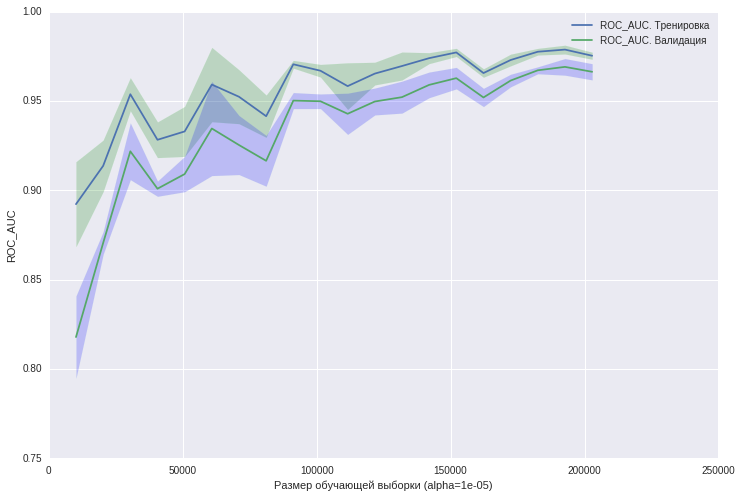

In [69]:
@use_result('my_load_data')
def task_learning_curve_alpha_rocauc2(train_features, train_targets, train_site_cnts, **kwargs):    
    visualize_learning_curve(alpha=0.00001, train_features=train_features, train_targets=train_targets, \
                             train_site_cnts=train_site_cnts)
    
task.call('learning_curve_alpha_rocauc2')

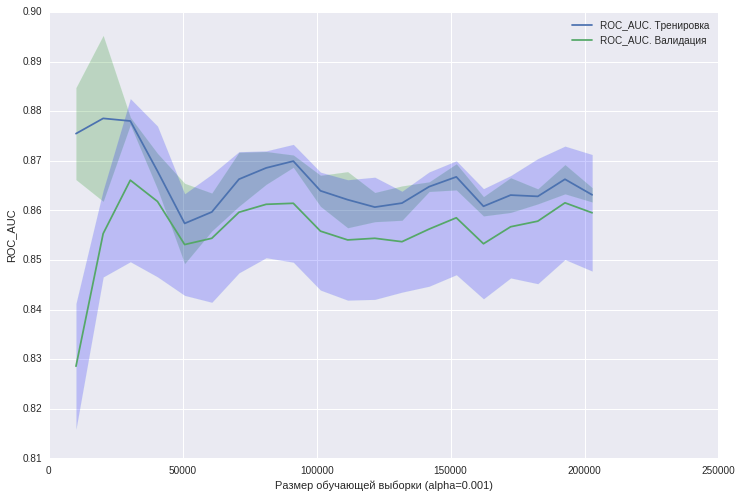

In [70]:
@use_result('my_load_data')
def task_learning_curve_alpha_rocauc3(train_features, train_targets, train_site_cnts, **kwargs):    
    visualize_learning_curve(alpha=0.001, train_features=train_features, train_targets=train_targets, \
                             train_site_cnts=train_site_cnts)
    
task.call('learning_curve_alpha_rocauc3')

**Вывод на основе кривых обучения.** Видно, что более или менее приемлый параметр *alpha = 0.0001* или *alpha = 0.00001.* Причём параметр по умолчанию *alpha = 0.0001* мне нравится больше из-за того, что кривые обучения более монотонные, с меньшими возвратами к более низким значениям метрики, чем при *alpha = 0.00001.* Монотонность возрастания метрики на валидационных данных при увеличении количества данных — хороший признак (модель постепенно улучшается при поступлении новых данных).

При *alpha=0.001*, во-первых, и сами значения метрики хуже (ось *y*), и модель очень быстро перестаёт накапливать информацию — уже после примерно 25000 строк кривая валидации указывает на отсутствие дальнейшего обучения — метрика **ROC_AUC** начинает случайно "гулять" вверх-вниз.

### 11. Оценка модели по метрикам. Возможность применения модели

Приблизительные метрики полученной модели:
* **Accuracy:** 0.991
* **Precision:** 0.694
* **Recall:** 0.103
* **Roc_auc:** 0.951

В связи с тем, что модель имеет неплохую метрику **precision,** она не очень часто ошибается, давая ложноположительный результат (т.е. определяя пользователи как Элис, если он на самом деле не-Элис). Т.к. данные несбалансированные, сессий Элис не очень много, не удалось достичь хорошей метрики **recall.** Останутся сессии Элис, так и не найденные моделью.

С другой стороны, если стоит задача обнаружить **не все** сессии Элис, но принадлежащие точно Элис, построенная модель окажет реальную помощь.

### 12. Модель на практике. Что ещё можно сделать

Данный классификатор можно легко приспособить для любых типов пользователей, в том числе для идентификации пользователей, которые тратят слишком много времени на нежелательных сайтах. Просмотр посещенных сайтов может осуществлять робот, что и надёжнее для работодателя, и этичнее по отношению к сотрудникам. Не отвлекаясь напрасно на списки посещенных сайтов, не тратя время, можно получать уведомление лишь в том случае, если Ваш сотрудник явно нарушает рабочий режим.

Для этого нужно обучить модель на данных конкретного сотрудника. Это может потребовать дополнительной настройки параметров вручную. Но, выполнив их один раз для конкретного сотрудника, мы можем применять модель для дальнейшего его обнаружения, уже не изменяя её.

### 13. Чего сделать не удалось

Как было упомянуто выше, модель имеет сравнительно невысокую метрику полноты обнаружения всех сессий пользователя. При накоплении большего числа данных по пользователю можно будет увеличить данную метрику.